In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy import stats as st
from random import randrange

In [40]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_hep.csv', index_col='CASEID')


In [41]:
data = data.drop(['Unnamed: 0'], axis=1)

In [42]:
data.shape

(25403, 70)

In [43]:
y = data['HEP_BILELEAKAGE']
X = data.drop(['HEP_BILELEAKAGE'], axis=1)

In [44]:
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
fold_no=0
for train_index, test_index in skf.split(data, y):
    train = data.loc[train_index,:]
    test = data.loc[test_index,:]
    train_filename = 'train' + str(fold_no) + '.csv'
    test_filename = 'test' + str(fold_no) + '.csv' 
    train.to_csv('splits/' + train_filename, index=False)
    test.to_csv('splits/' + test_filename, index=False) 
    fold_no += 1

In [45]:
d = {}
for x in range(1,6):
    d['train{}'.format(x)] = pd.read_csv('splits/train{}.csv'.format(x), low_memory=False)
    d['test{}'.format(x)] = pd.read_csv('splits/test{}.csv'.format(x), low_memory=False)

In [46]:
for x in range(1,6):
    print(len(d['test1']))

5081
5081
5081
5081
5081


In [47]:
dX_train = []
dy_train = []
for x in d:
    if 'train' in x:
        dX_train.append(d[x].drop(columns=['HEP_BILELEAKAGE'], axis=1))
        dy_train.append(d[x]['HEP_BILELEAKAGE'])

In [48]:
dX_test = []
dy_test = []
for x in d:
    if 'test' in x:
        dX_test.append(d[x].drop(columns=['HEP_BILELEAKAGE'], axis=1))
        dy_test.append(d[x]['HEP_BILELEAKAGE'])

rfpreds = []
xgbpreds = []
model = RandomForestClassifier(n_estimators=1250, min_samples_split=2, min_samples_leaf=8, max_features='auto', max_depth=20, bootstrap=True)
model2 = XGBClassifier(n_estimators=50, subsample=0.6, min_child_weight=10, max_depth=6, learning_rate=0.1, colsample_bytree=0.8)
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model.fit(X, y)
    model2.fit(X, y)
    rfpreds.append(model.predict_proba(X_test))
    xgbpreds.append(model2.predict_proba(X_test))

%store rfpreds
%store xgbpreds

for x in range(1,6):
    print(roc_auc_score(dy_test[x], rfpreds[x][:,1]))
    

for x in range(1,6):
    print(roc_auc_score(dy_test[x], xgbpreds[x][:,1]))

In [49]:
from tensorflow import keras
input_shape = [dX_train[1].shape[1]]
model4 = keras.models.Sequential()
model4.add(keras.layers.Flatten(input_shape=input_shape))
model4.add(keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(keras.layers.Dense(1000))
    model4.add(keras.layers.BatchNormalization())
    model4.add(keras.layers.Dropout(0.8))
    model4.add(keras.layers.Activation("relu"))
model4.add(keras.layers.Dense(1, activation="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=3e-4)

metrics = [keras.metrics.Recall(name='Sensitivity'), keras.metrics.TrueNegatives(name='tn'), keras.metrics.AUC(name='auc'), keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.00001,
    restore_best_weights=True,)


In [50]:
annpreds = []
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
    model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping])
    annpreds.append(model4.predict(X_test))

Epoch 1/200
30/30 [==============================] - 2s 30ms/step - loss: 0.4475 - Sensitivity: 0.1922 - tn: 12550.0000 - auc: 0.5167 - prc: 0.0415 - val_loss: 1.4602 - val_Sensitivity: 1.0000 - val_tn: 1.0000 - val_auc: 0.6611 - val_prc: 0.0743
Epoch 2/200
30/30 [==============================] - 0s 12ms/step - loss: 0.2401 - Sensitivity: 0.0511 - tn: 14386.0000 - auc: 0.5121 - prc: 0.0464 - val_loss: 0.6511 - val_Sensitivity: 0.5879 - val_tn: 3391.0000 - val_auc: 0.6852 - val_prc: 0.0867
Epoch 3/200
30/30 [==============================] - 0s 13ms/step - loss: 0.2138 - Sensitivity: 0.0317 - tn: 14502.0000 - auc: 0.5722 - prc: 0.0545 - val_loss: 0.5144 - val_Sensitivity: 0.3618 - val_tn: 4309.0000 - val_auc: 0.6969 - val_prc: 0.0911
Epoch 4/200
30/30 [==============================] - 0s 13ms/step - loss: 0.2140 - Sensitivity: 0.0441 - tn: 14474.0000 - auc: 0.6030 - prc: 0.0602 - val_loss: 0.3916 - val_Sensitivity: 0.2312 - val_tn: 4587.0000 - val_auc: 0.7030 - val_prc: 0.0918
Epoch 5

In [51]:
ann_score = []
for x in range(0,5):
    ann_score.append(roc_auc_score(dy_test[x], annpreds[x]))
ann_score

[0.740339069862733,
 0.7378020747728111,
 0.790027628271271,
 0.7577701836544609,
 0.7550797869751049]

model.fit(dX_train[0], dy_train[0])
def rf_feat_importance(model, X):
    return pd.DataFrame({'cols':X.columns, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(model, X)
fi[:10]
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:20]);

model2.fit(dX_train[0], dy_train[0])
fi = rf_feat_importance(model2, X)
plot_fi(fi[:20]);

In [52]:
lrpreds = []
model3 = LogisticRegression()
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model3.fit(X, y)
    lrpreds.append(model3.predict_proba(X_test))

/home/kchen/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kchen/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

In [53]:
lr_score = []
for x in range(0,5):
    lr_score.append(roc_auc_score(dy_test[x], lrpreds[x][:,1]))

In [54]:
lr_score

[0.7035484531858226,
 0.7177868295994568,
 0.7151693551278628,
 0.7417554540842213,
 0.7417554540842213]

In [55]:
ann_mean = np.mean(ann_score)
ann_confidence = st.t.interval(0.95, len(ann_score)-1, loc=ann_mean, scale=st.sem(ann_score))

print('Neural Network:', round(ann_mean,3), '('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')')

Neural Network: 0.756 (0.73-0.782)


In [56]:
lr_mean = np.mean(lr_score)
lr_confidence = st.t.interval(0.95, len(lr_score)-1, loc=lr_mean, scale=st.sem(lr_score))

print('Logistic Regression:', round(lr_mean,3), '('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')')

Logistic Regression: 0.724 (0.703-0.745)


In [57]:
ann_prc = []
for x in range(0,5):
    ann_prc.append(average_precision_score(dy_test[x], annpreds[x]))

ann_prc_mean = np.mean(ann_prc)
ann_prc_confidence = st.t.interval(0.95, len(ann_prc)-1, loc=ann_prc_mean, scale=st.sem(ann_prc))

print('Neural Network:', round(ann_prc_mean,3), '('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')

Neural Network: 0.134 (0.085-0.183)


In [58]:
lr_prc = []
for x in range(0,5):
    lr_prc.append(average_precision_score(dy_test[x], lrpreds[x][:,1]))

lr_prc_mean = np.mean(lr_prc)
lr_prc_confidence = st.t.interval(0.95, len(lr_prc)-1, loc=lr_prc_mean, scale=st.sem(lr_prc))

print('Logistic Regression:', round(lr_prc_mean,3), '('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')')

Logistic Regression: 0.097 (0.086-0.108)


In [59]:
with open('hep_results.txt', 'w') as f:
    f.write('Logistic Regression: '+str(round(lr_mean,3))+' ('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_mean,3))+' ('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')\n')
    f.write('AUPRC\n')
    f.write('Logistic Regression: '+str(round(lr_prc_mean,3))+' ('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_prc_mean,3))+' ('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')

In [60]:
hep_ann_tpr = []
hep_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x], drop_intermediate=False)
    hep_ann_tpr.append(tpr)
    hep_ann_fpr.append(fpr)


In [61]:
for x in range(0,5):
    print(len(hep_ann_tpr[x]))

5081
5080
5080
5079
5080


for x in range(0,5):
    diff = len(hep_ann_tpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_ann_tpr[x]))
        hep_ann_tpr[x] = np.delete(hep_ann_tpr[x],ind)
for x in range(0,5):
    diff = len(hep_ann_fpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_ann_fpr[x]))
        hep_ann_fpr[x] = np.delete(hep_ann_fpr[x],ind)


In [62]:
mean_hep_ann_tpr = [np.mean(k) for k in zip(*hep_ann_tpr)]
mean_hep_ann_fpr = [np.mean(k) for k in zip(*hep_ann_fpr)]
%store mean_hep_ann_tpr
%store mean_hep_ann_fpr


Stored 'mean_hep_ann_tpr' (list)
Stored 'mean_hep_ann_fpr' (list)


In [63]:

hep_lr_tpr = []
hep_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_tpr.append(tpr)
    hep_lr_fpr.append(fpr)
for x in range(0,5):
    diff = len(hep_lr_tpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_lr_tpr[x]))
        hep_lr_tpr[x] = np.delete(hep_lr_tpr[x],ind)

for x in range(0,5):
    diff = len(hep_lr_fpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_lr_fpr[x]))
        hep_lr_fpr[x] = np.delete(hep_lr_fpr[x],ind)


mean_hep_lr_tpr = [np.mean(k) for k in zip(*hep_lr_tpr)]
mean_hep_lr_fpr = [np.mean(k) for k in zip(*hep_lr_fpr)]
%store mean_hep_lr_tpr
%store mean_hep_lr_fpr


Stored 'mean_hep_lr_tpr' (list)
Stored 'mean_hep_lr_fpr' (list)


In [64]:

hep_lr_rec = []
hep_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_rec.append(rec)
    hep_lr_prec.append(prec)


In [65]:
for x in range(0,5):
    print(len(hep_lr_rec[x]))

4970
4982
4866
5047
5047


In [66]:

for x in range(0,5):
    diff = len(hep_lr_rec[x]) - 4800
    for _ in range(diff):
        ind = randrange(len(hep_lr_rec[x]))
        hep_lr_rec[x] = np.delete(hep_lr_rec[x],ind)

for x in range(0,5):
    diff = len(hep_lr_prec[x]) - 4800
    for _ in range(diff):
        ind = randrange(len(hep_lr_prec[x]))
        hep_lr_prec[x] = np.delete(hep_lr_prec[x],ind)

mean_hep_lr_rec = [np.mean(k) for k in zip(*hep_lr_rec)]
mean_hep_lr_prec = [np.mean(k) for k in zip(*hep_lr_prec)]
%store mean_hep_lr_rec
%store mean_hep_lr_prec


Stored 'mean_hep_lr_rec' (list)
Stored 'mean_hep_lr_prec' (list)


In [67]:
from matplotlib import pyplot as plt

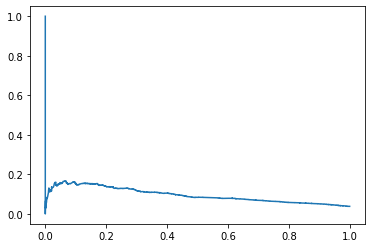

In [68]:
plt.plot(mean_hep_lr_rec, mean_hep_lr_prec)

In [69]:

hep_ann_rec = []
hep_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    hep_ann_rec.append(rec)
    hep_ann_prec.append(prec)

for x in range(0,5):
    diff = len(hep_ann_rec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(hep_ann_rec[x]))
        hep_ann_rec[x] = np.delete(hep_ann_rec[x],ind)

for x in range(0,5):
    diff = len(hep_ann_prec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(hep_ann_prec[x]))
        hep_ann_prec[x] = np.delete(hep_ann_prec[x],ind)

mean_hep_ann_rec = [np.mean(k) for k in zip(*hep_ann_rec)]
mean_hep_ann_prec = [np.mean(k) for k in zip(*hep_ann_prec)]
%store mean_hep_ann_rec
%store mean_hep_ann_prec

Stored 'mean_hep_ann_rec' (list)
Stored 'mean_hep_ann_prec' (list)


hep_ann_tpr = []
hep_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x])
    hep_ann_tpr.append(tpr)
    hep_ann_fpr.append(fpr)
hep_ann_tpr_array = [np.array(x) for x in hep_ann_tpr]
mean_hep_ann_tpr = [np.mean(k) for k in zip(*hep_ann_tpr_array)]
hep_ann_fpr_array = [np.array(x) for x in hep_ann_fpr]
mean_hep_ann_fpr = [np.mean(k) for k in zip(*hep_ann_fpr_array)]
%store mean_hep_ann_tpr
%store mean_hep_ann_fpr

hep_lr_tpr = []
hep_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_tpr.append(tpr)
    hep_lr_fpr.append(fpr)
hep_lr_tpr_array = [np.array(x) for x in hep_lr_tpr]
mean_hep_lr_tpr = [np.mean(k) for k in zip(*hep_lr_tpr_array)]
hep_lr_fpr_array = [np.array(x) for x in hep_lr_fpr]
mean_hep_lr_fpr = [np.mean(k) for k in zip(*hep_lr_fpr_array)]
%store mean_hep_lr_tpr
%store mean_hep_lr_fpr
hep_ann_rec = []
hep_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    hep_ann_rec.append(rec)
    hep_ann_prec.append(prec)
hep_ann_rec_array = [np.array(x) for x in hep_ann_rec]
mean_hep_ann_rec = [np.mean(k) for k in zip(*hep_ann_rec_array)]
hep_ann_prec_array = [np.array(x) for x in hep_ann_prec]
mean_hep_ann_prec = [np.mean(k) for k in zip(*hep_ann_prec_array)]
%store mean_hep_ann_rec
%store mean_hep_ann_prec

hep_lr_rec = []
hep_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_rec.append(rec)
    hep_lr_prec.append(prec)
hep_lr_rec_array = [np.array(x) for x in hep_lr_rec]
mean_hep_lr_rec = [np.mean(k) for k in zip(*hep_lr_rec_array)]
hep_lr_prec_array = [np.array(x) for x in hep_lr_prec]
mean_hep_lr_prec = [np.mean(k) for k in zip(*hep_lr_prec_array)]
%store mean_hep_lr_rec
%store mean_hep_lr_prec


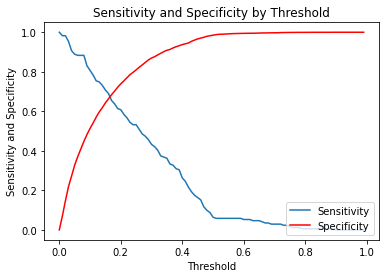

In [70]:
from imblearn.metrics import specificity_score
thresh = np.arange(0, 1, 0.01)
#calculate recall at 10 thresholds
annrecall_list = []
for i in thresh:
    annrecall_list.append(recall_score(dy_test[1], annpreds[1] > i))
#calculate spec at 10 thresholds
annspec_list = []
for i in thresh:
    annspec_list.append(specificity_score(dy_test[1], annpreds[1] > i))
from matplotlib import pyplot as plt
#plot recall vs threshold
plt.plot(thresh, annrecall_list, label = 'Sensitivity')
plt.plot(thresh, annspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()
thresh = np.arange(0, 1, 0.01)


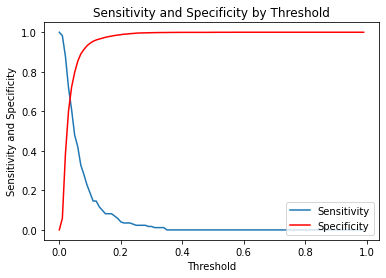

In [71]:
#calculate recall at 10 thresholds
lrrecall_list = []
for i in thresh:
    lrrecall_list.append(recall_score(dy_test[1], lrpreds[1][:,1] > i))
#calculate spec at 10 thresholds
lrspec_list = []
for i in thresh:
    lrspec_list.append(specificity_score(dy_test[1], lrpreds[1][:,1] > i))
from matplotlib import pyplot as plt
#plot recall vs threshold
plt.plot(thresh, lrrecall_list, label = 'Sensitivity')
plt.plot(thresh, lrspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()


In [72]:
print(recall_score(dy_test[1], lrpreds[1][:,1] > 0.03))
print(specificity_score(dy_test[1], lrpreds[1][:,1] > 0.03))


0.7192982456140351
0.6008146639511202


In [73]:
print(recall_score(dy_test[1], annpreds[1] > 0.125))
print(specificity_score(dy_test[1], annpreds[1] > 0.125))

0.7543859649122807
0.5869653767820774


In [74]:
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics

def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    

def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))


p = []
z = []
# Model A (random) vs. "good" model B
for x in range(0,5):
    preds_A = annpreds[x]
    preds_B = lrpreds[x][:,1]
    actual = dy_test[x]

    actual = actual.array

    def group_preds_by_label(preds, actual):
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y


    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)
    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)
    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)


    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z.append(z_score(var_A, var_B, covar_AB, auc_A, auc_B))
    p.append(st.norm.sf(abs(z[x-1]))*2)


In [75]:
p

[0.0008414236000672049,
 0.0008414236000672049,
 0.06992098180299783,
 9.733662959044024e-09,
 0.1856597792893646]

In [76]:
sum(p)/(len(p))

0.05145272360523197